<a href="https://colab.research.google.com/github/atharvasatishchaudhari/Neural_Networks-/blob/main/Residual_Connections_and_One_Cycle_Policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch-lr-finder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Starting LR Range Test...


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.72E-05


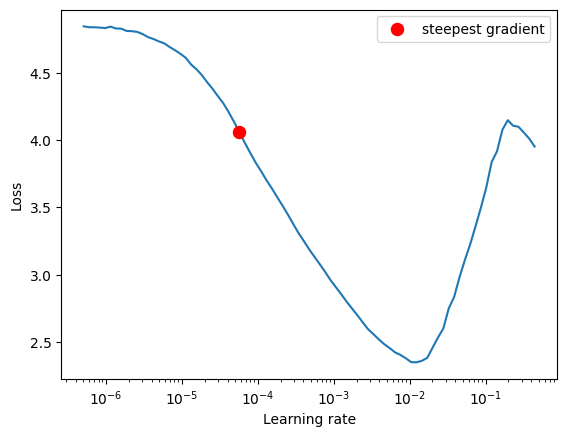

Chosen lr_max for training: 0.01
Epoch [1/24] - Loss: 1.6343, Train Acc: 44.43%
          Test Loss: 1.3401, Test Acc: 54.64%
Epoch [2/24] - Loss: 0.9999, Train Acc: 64.83%
          Test Loss: 0.8664, Test Acc: 71.01%
Epoch [3/24] - Loss: 0.8011, Train Acc: 72.24%
          Test Loss: 1.3591, Test Acc: 61.42%
Epoch [4/24] - Loss: 0.7962, Train Acc: 73.60%
          Test Loss: 1.2095, Test Acc: 69.08%
Epoch [5/24] - Loss: 0.7011, Train Acc: 76.76%
          Test Loss: 0.9477, Test Acc: 73.67%
Epoch [6/24] - Loss: 0.5756, Train Acc: 80.73%
          Test Loss: 0.4839, Test Acc: 83.85%
Epoch [7/24] - Loss: 0.4732, Train Acc: 83.88%
          Test Loss: 0.5985, Test Acc: 80.96%
Epoch [8/24] - Loss: 0.3995, Train Acc: 86.34%
          Test Loss: 0.4587, Test Acc: 85.42%
Epoch [9/24] - Loss: 0.3651, Train Acc: 87.34%
          Test Loss: 0.4538, Test Acc: 85.48%
Epoch [10/24] - Loss: 0.3197, Train Acc: 88.99%
          Test Loss: 0.3975, Test Acc: 86.68%
Epoch [11/24] - Loss: 0.2904, Train 

In [4]:
# custom_resnet_lr_finder.py

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import random
from torch_lr_finder import LRFinder  # Make sure to install via pip install torch-lr-finder
import matplotlib.pyplot as plt

#########################
# Residual Block Module #
#########################
class ResidualBlock(nn.Module):
    """
    A basic residual block with two convolutional layers.
    Each convolution is 3x3 with stride=1 and padding=1.
    BatchNorm and ReLU are applied after each convolution.
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

###############################
# Custom ResNet Architecture  #
###############################
class CustomResNet(nn.Module):
    """
    Custom ResNet for CIFAR10 with the following architecture:

    PrepLayer:
      Conv 3x3 (s1, p1) >> BN >> ReLU [64 channels]

    Layer 1:
      X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> ReLU [128 channels]
      R1 = ResidualBlock(128)
      Output = X + R1

    Layer 2:
      Conv 3x3 >> MaxPool2D >> BN >> ReLU [256 channels]

    Layer 3:
      X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> ReLU [512 channels]
      R2 = ResidualBlock(512)
      Output = X + R2
      Then a final MaxPool (kernel size 4) is applied before the FC layer.

    The FC layer outputs logits for 10 classes.
    """
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        # PrepLayer: 3 input channels -> 64 channels
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Layer 1: 64 -> 128 channels
        self.layer1_conv = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),  # Example: 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.resblock1 = ResidualBlock(128)

        # Layer 2: 128 -> 256 channels
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Layer 3: 256 -> 512 channels
        self.layer3_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),  # 8x8 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.resblock2 = ResidualBlock(512)
        # Final pooling: kernel size of 4 reduces 4x4 to 1x1
        self.final_pool = nn.MaxPool2d(kernel_size=4)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # PrepLayer
        x = self.prep(x)
        # Layer 1 with residual connection
        x = self.layer1_conv(x)
        r1 = self.resblock1(x)
        x = x + r1

        # Layer 2 (without a residual connection)
        x = self.layer2(x)

        # Layer 3 with residual connection
        x = self.layer3_conv(x)
        r2 = self.resblock2(x)
        x = x + r2

        # Final pooling and classification
        x = self.final_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

###########################
# Custom Data Transforms  #
###########################
class Cutout(object):
    """
    Applies Cutout augmentation by zeroing out a random square region in the image.
    mask_size: side length of the square to cut out.
    p: probability with which Cutout is applied.
    """
    def __init__(self, mask_size, p=1.0):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        # img is expected to be a Tensor with shape [C, H, W]
        if random.random() > self.p:
            return img
        _, H, W = img.shape
        mask_size = self.mask_size
        top = random.randint(0, H - mask_size)
        left = random.randint(0, W - mask_size)
        img[:, top:top+mask_size, left:left+mask_size] = 0.0
        return img

def get_data_loaders(batch_size=512, num_workers=2):
    """
    Returns CIFAR10 train and test loaders.
    Train transform:
      - Pad the image by 4 pixels on each side
      - Random crop to 32x32
      - Random horizontal flip
      - Convert to Tensor
      - Apply Cutout (mask size 8x8)
      - Normalize using CIFAR10 mean and std.
    Test transform:
      - Convert to Tensor and normalize.
    """
    transform_train = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        Cutout(mask_size=8, p=1.0),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True,
                                     download=True, transform=transform_train)
    test_dataset  = datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)
    test_loader  = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=num_workers)
    return train_loader, test_loader

##############################
# Training Loop with One Cycle Policy
##############################
def train(model, train_loader, test_loader, device, epochs=24, lr_max=0.01, lr_min=None):
    """
    Train the model using the ADAM optimizer, CrossEntropyLoss,
    and the One Cycle Learning Rate Policy.

    Parameters:
      model: the network (CustomResNet)
      train_loader, test_loader: CIFAR10 data loaders
      device: 'cuda' or 'cpu'
      epochs: total epochs to train (24)
      lr_max: maximum learning rate (chosen from a range test)
      lr_min: minimum learning rate (if None, set as lr_max/10)

    The One Cycle scheduler is set so that the maximum learning rate is reached at epoch 5.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    if lr_min is None:
        lr_min = lr_max / 10.0

    # OneCycleLR scheduler setup:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr_max,
        total_steps=epochs * len(train_loader),
        pct_start=5/epochs,  # maximum LR reached at epoch 5
        anneal_strategy='linear'
    )

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

        # Evaluate on test data
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += targets.size(0)
                correct_test += predicted.eq(targets).sum().item()
        test_acc = 100. * correct_test / total_test
        print(f"          Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_acc:.2f}%")

    return model

##############################
# Main: LR Finder and Training
##############################
if __name__ == '__main__':
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get data loaders
    train_loader, test_loader = get_data_loaders(batch_size=512)

    # Initialize the model
    model = CustomResNet(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()

    # Initialize the optimizer with a very low LR for LR finder
    optimizer = optim.Adam(model.parameters(), lr=1e-7)

    print("Starting LR Range Test...")
    # Initialize LR Finder
    lr_finder = LRFinder(model, optimizer, criterion, device=device)

    # Run LR range test over 100 iterations, increasing LR up to 1.0
    lr_finder.range_test(train_loader, end_lr=1.0, num_iter=100)

    # Plot the loss vs. LR. Examine this plot to pick a good lr_max.
    lr_finder.plot()
    plt.show()  # Ensure the plot window stays open

    # Reset model and optimizer to initial state
    lr_finder.reset()

    # After examining the plot, choose an appropriate lr_max.
    # For example, if the plot suggests a good maximum LR is 0.01:
    lr_max = 0.01
    print(f"Chosen lr_max for training: {lr_max}")

    # Reinitialize the optimizer for training with the chosen lr_max schedule.
    optimizer = optim.Adam(model.parameters(), lr=lr_max/10)  # starting LR can be lower

    # Train the model with the One Cycle Policy.
    trained_model = train(model, train_loader, test_loader, device, epochs=24, lr_max=lr_max)
